# Simple Q-learning agent

The notebook provides a quick training of [Q-learning](https://link.springer.com/article/10.1007/bf00992698) algorithm on the `ElevatorEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
from collections import OrderedDict
from gymnasium.utils.env_checker import check_env
import gymnasium as gym

from gym4real.envs.elevator.utils import parameter_generator

In [3]:
sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.2)

## DQN Agent
We are adopting a custom version of Q-Learning to solve the tabular MDP.

In [10]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

In [11]:
n_episodes = 25
n_envs = 4

In [12]:
params = parameter_generator(lambda_min=0.01, lambda_max=0.1, seed=42)
params

{'min_floor': 0,
 'max_floor': 4,
 'max_capacity': 4,
 'movement_speed': 3.0,
 'floor_height': 6,
 'max_arrivals': 2,
 'max_queue_length': 3,
 'duration': 3600,
 'timestep': 1,
 'goal_floor': 0,
 'init_elevator_pos': None,
 'random_init_state': False,
 'arrival_distributions': {'lambda_min': 0.01, 'lambda_max': 0.1, 'seed': 42}}

In [13]:
envs = make_vec_env("gym4real/elevator-v0",  n_envs=n_envs, env_kwargs={'settings':params})

/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


In [14]:
model = DQN("MultiInputPolicy", envs)
model.learn(total_timesteps=params['duration'] * n_episodes * n_envs, 
            progress_bar=True)
model.save('examples/elevator/trained_models/DQN_quick')

Output()

## Comparison with Random policy

Here we will compare the DQN model saved with a simple random policy. The policies will be compared on several arrival profiles with another seed.

In [28]:
eval_params = parameter_generator(seed=1234)

eval_episodes = 30
rewards = {}

### Random Policy
The action is chosen randomly at each decision step by randomly sampling within the action space.

In [36]:
env = gym.make("gym4real/elevator-v0", **{'settings':eval_params})

alg = 'random'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset(options={'is_evaluation': True})
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
    
    while not done:
        action = env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode].append(cumulated_reward)

 20%|█████████████████████████████                                                                                                                    | 6/30 [00:00<00:00, 24.50it/s]

0
0
0
0
0
0
0
0


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 12/30 [00:00<00:00, 24.94it/s]

0
0
0
0
0
0
0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 21/30 [00:00<00:00, 25.28it/s]

0
0
0
0
0
0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27/30 [00:01<00:00, 25.39it/s]

0
0
0
0
0
0
0
0
0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.98it/s]


### Longest Queue First Policy

In [30]:
env = gym.make("gym4real/elevator-v0", **{'settings':eval_params})

alg = 'longest_queue_first'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset(options={'is_evaluation': True})
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
        
    while not done:
        if obs['n_passengers'] > 0:
            if obs['current_position'] * info['movement_speed'] / info['floor_height'] == info['goal_floor']:
                action = 1  # stay still
            else:
                action = 0  # move down
        else:
            # Check if any passengers are waiting on the current floor
            len_max_queue, idx_max_queue = max((queue, idx+1) for idx, queue in enumerate(obs['floor_queues']))
            
            if len_max_queue == 0:
                action = 1  # stay still
            else:
                if obs['current_position'] * info['movement_speed'] == (idx_max_queue) * info['floor_height']:
                    action = 1  # stay still
                elif obs['current_position'] * info['movement_speed'] < (idx_max_queue) * info['floor_height']:
                    action = 2  # move up            
                elif obs['current_position'] * info['movement_speed'] > (idx_max_queue) * info['floor_height']:
                    action = 0
                else:
                    action = 1
                    
        obs, reward, terminated, truncated, info = env.step(action)
        cumulated_reward += reward
        done = terminated or truncated
        rewards[alg][episode].append(cumulated_reward)
        #pprint(f"Episode: {episode}, Step: {info['current_time']}, Action: {action}, "f"Reward: {reward}, Cumulative Reward: {cumulated_reward}, " 
        #f"Current Pos: {obs['current_position']}, Passengers: {obs['n_passengers']}, " f"Queues: {obs['floor_queues']}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.25it/s]


### DQN agent
Here we load the previously created model `DQN_quick`.

In [31]:
env = make_vec_env("gym4real/elevator-v0", n_envs=1, env_kwargs={'settings':eval_params})

alg = 'dqn'
rewards[alg] = {}

model = DQN('MultiInputPolicy', env, verbose=1)
vec_env = model.get_env()
model = DQN.load("examples/elevator/trained_models/DQN_quick")

for episode in tqdm(range(eval_episodes)):
    vec_env.set_options({'is_evaluation': True})
    obs = vec_env.reset()

    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
    
    while not done:
        action, _states = model.predict(obs)
        obs, r, dones, info = vec_env.step(action)
        done = dones[0]
        cumulated_reward += r[0]
        rewards[alg][episode].append(cumulated_reward)

Using cpu device


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.61it/s]


Let's compare the cumulative rewards averaged among the test profiles between `DQN` undergone a quick training and the `random` policy.

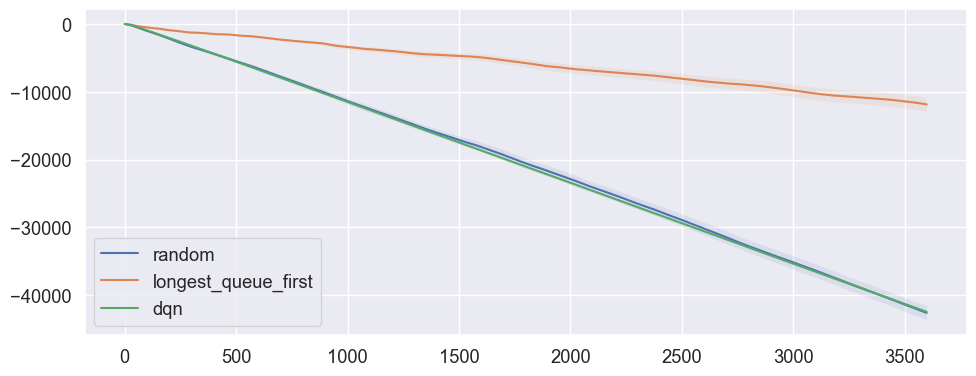

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for i, alg in enumerate(rewards.keys()):
    means = np.mean([(rewards[alg][profile]) for profile in rewards[alg].keys()], axis=0)
    stds = np.std([(rewards[alg][profile]) for profile in rewards[alg].keys()], axis=0)
    ci = 1.96 * stds/np.sqrt(len(rewards[alg].keys()))
    
    ax.plot(means, label=alg)        
    ax.fill_between(range(len(means)), means + ci, means - ci, alpha=0.1)
    ax.legend()